# Setup workspace

In [ ]:
pip install -r requirements.txt

In [1]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [2]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

Found the config file in: /config.json


# Import data

In [3]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# load the dataset
print("Loading Data...")
df = pd.read_csv('data/breast-cancer.data')

Loading Data...


In [4]:
df

,recurence,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


# Create a data asset

In [5]:
from azure.ai.ml.entities import Data

# Create a Data asset
data_asset = Data(
    path="data/breast-cancer.data",
    type="uri_file",
    name="cancer-data",
    description="Cancer data CSV file"
)

# Upload the data asset
ml_client.data.create_or_update(data_asset)

Data({'path': 'azureml://subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/housing_prices/workspaces/mlw-housing_prices/datastores/workspaceblobstore/paths/LocalUpload/3e28c2b024c43e7f9d7b04e56af90b9e/breast-cancer.data', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'cancer-data', 'description': 'Cancer data CSV file', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/housing_prices/providers/Microsoft.MachineLearningServices/workspaces/mlw-housing_prices/data/cancer-data/versions/9', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/ci-housing-all/code/Users/noam.chretiennot/cloud-DP100-project', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f55b7180e20>, 'serialize': <msrest

# Prepare data

In [6]:
df = df[df["node-caps"] != "?"]
df = df[df["breast-quad"] != "?"]

X = df.drop("recurence", axis=1)
X["age"] = X["age"].apply(lambda x: int(x[0]))
X["menopause"] = X["menopause"].apply(lambda x: 1 if x == "lt40" else (2 if x == "ge40" else 3))
X["tumor-size"] = X["tumor-size"].apply(lambda x: int(x[0]))
X["inv-nodes"] = X["inv-nodes"].apply(lambda x: int(x[0]))
X["node-caps"] = X["node-caps"].apply(lambda x: 1 if x == "yes" else 0)
X["breast"] = X["breast"].apply(lambda x: 1 if x == "left" else 0)
X = pd.get_dummies(X, columns=["breast-quad"])
X["irradiat"] = X["irradiat"].apply(lambda x: 1 if x == "yes" else 0)

y = df["recurence"]
y= y.apply(lambda x: 1 if x == "recurrence-events" else 0)

In [7]:
X

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,irradiat,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,3,3,3,0,0,3,1,0,False,True,False,False,False
1,4,3,2,0,0,2,0,0,False,False,False,False,True
2,4,3,2,0,0,2,1,0,False,True,False,False,False
3,6,2,1,0,0,2,0,0,False,False,True,False,False
4,4,3,0,0,0,2,0,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,3,3,3,0,0,2,1,0,False,False,True,False,False
282,3,3,2,0,0,3,1,1,False,False,True,False,False
283,6,2,2,0,0,1,0,0,False,False,True,False,False
284,4,2,3,3,0,3,1,0,False,True,False,False,False


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'menopause'}>,
        <Axes: title={'center': 'tumor-size'}>],
       [<Axes: title={'center': 'inv-nodes'}>,
        <Axes: title={'center': 'node-caps'}>,
        <Axes: title={'center': 'deg-malig'}>],
       [<Axes: title={'center': 'breast'}>,
        <Axes: title={'center': 'irradiat'}>, <Axes: >]], dtype=object)

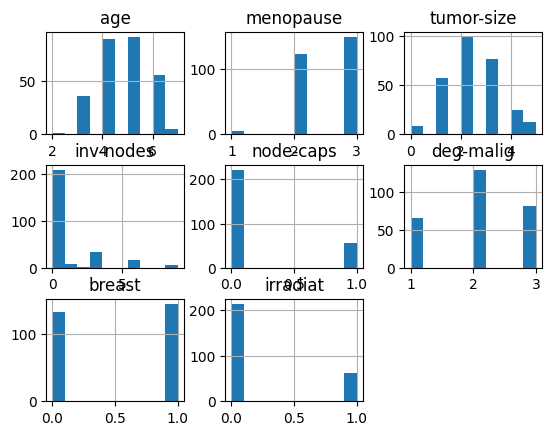

In [8]:
X.hist()

<Axes: >

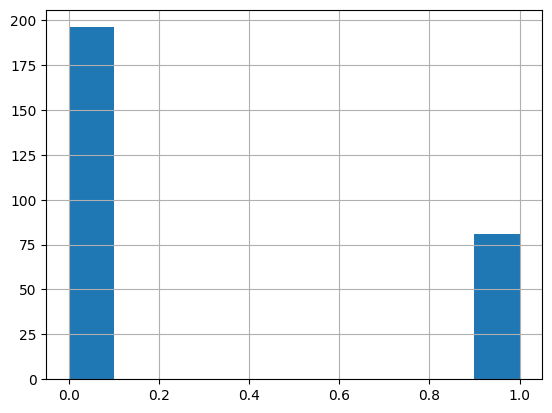

In [9]:
y.hist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# over sample so the minority class represents 70% of the data
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



<Axes: >

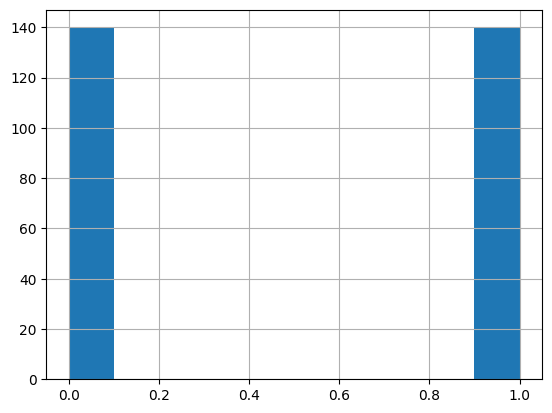

In [12]:
y_train_resampled.hist()

# Test models

In [13]:
import mlflow
experiment_name = "mlflow-breast-cancer"
mlflow.set_experiment(experiment_name)
mlflow.sklearn.autolog(disable=True)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/azureml/mlflow/_protos/aml_service_pb2.py:10: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


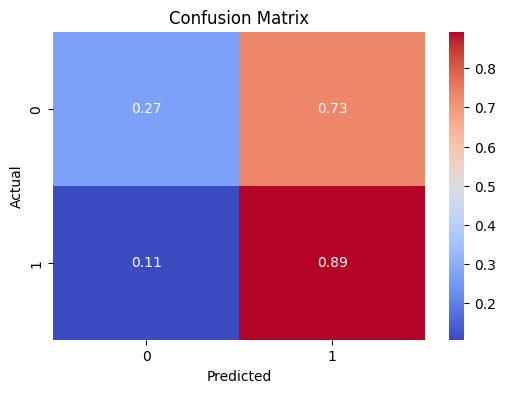

In [14]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

with mlflow.start_run():
    model = LogisticRegression(class_weight={0:1, 1:6}).fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)
    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    mlflow.log_param("model", "logistic regression base")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

2025/01/26 12:40:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run sleepy_spring_bby722w1 at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/housing_prices/providers/Microsoft.MachineLearningServices/workspaces/mlw-housing_prices/#/experiments/85453ebe-e75a-4a14-aed7-f9c46f2c4f98/runs/7276b61a-1c2d-49f1-b208-0b6362ecc686.
2025/01/26 12:40:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/housing_prices/providers/Microsoft.MachineLearningServices/workspaces/mlw-housing_prices/#/experiments/85453ebe-e75a-4a14-aed7-f9c46f2c4f98.


<Figure size 600x400 with 0 Axes>

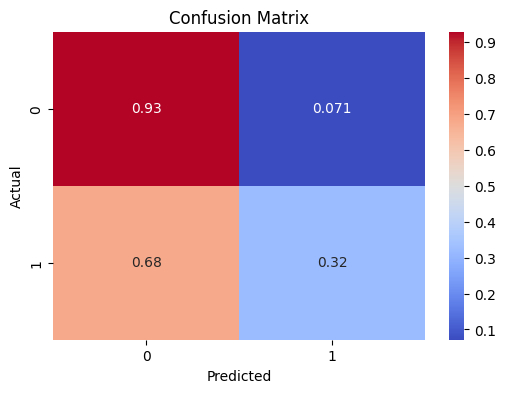

In [87]:
from xgboost import XGBClassifier

with mlflow.start_run():
    model = XGBClassifier().fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)
    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    mlflow.log_param("model", "xgboost")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)
    fig = plt.figure(figsize=(6, 4)) 
    
    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

2025/01/26 15:37:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat_tiger_57mlchxw at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/housing_prices/providers/Microsoft.MachineLearningServices/workspaces/mlw-housing_prices/#/experiments/85453ebe-e75a-4a14-aed7-f9c46f2c4f98/runs/96e3f8ef-5b7d-405c-8e2b-df6d3e34e2c5.
2025/01/26 15:37:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/housing_prices/providers/Microsoft.MachineLearningServices/workspaces/mlw-housing_prices/#/experiments/85453ebe-e75a-4a14-aed7-f9c46f2c4f98.


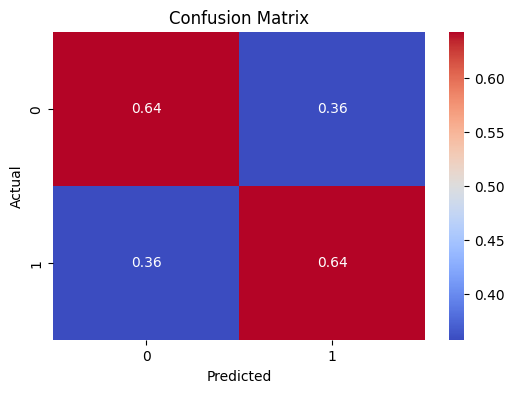

In [15]:
from sklearn.svm import SVC

with mlflow.start_run():
    mlflow.set_tag("mlflow.job", "SVM")
    model = SVC(class_weight={0:1, 1:3.8}).fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    mlflow.log_param("model", "svm")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)
    
    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

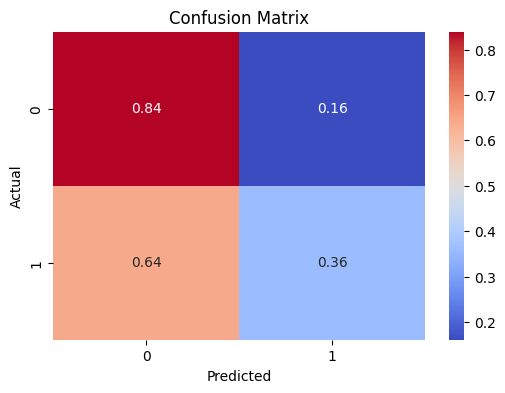

In [16]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    model = RandomForestClassifier().fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)
    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    mlflow.log_param("model", "random forest")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)
    
    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

Logistic regression is the best model

In [18]:
# Search for all runs
runs = mlflow.search_runs()

# order by "metrics.Accuracy"
runs = runs.sort_values(by=["metrics.ROC_AUC"], ascending=False)
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.ROC_AUC,metrics.Accuracy,params.model,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.rootRunId,tags.mlflow.job
1,96e3f8ef-5b7d-405c-8e2b-df6d3e34e2c5,85453ebe-e75a-4a14-aed7-f9c46f2c4f98,FINISHED,,2025-01-26 15:37:01.007000+00:00,2025-01-26 15:37:02.972000+00:00,0.642857,0.642857,svm,Noam CHRETIENNOT,upbeat_tiger_57mlchxw,96e3f8ef-5b7d-405c-8e2b-df6d3e34e2c5,SVM
2,a423c514-d612-46d2-a6c4-1fbb0bc77cdb,85453ebe-e75a-4a14-aed7-f9c46f2c4f98,FINISHED,,2025-01-26 15:37:03.687000+00:00,2025-01-26 15:37:05.797000+00:00,0.598214,0.678571,random forest,Noam CHRETIENNOT,gentle_cherry_qwxwgxq3,a423c514-d612-46d2-a6c4-1fbb0bc77cdb,None
0,7d213c97-b6bf-4923-b0e8-6f68eb4847ac,85453ebe-e75a-4a14-aed7-f9c46f2c4f98,FINISHED,,2025-01-26 15:36:57.140000+00:00,2025-01-26 15:36:58.943000+00:00,0.580357,0.476190,logistic regression base,Noam CHRETIENNOT,keen_stomach_wvvdc637,7d213c97-b6bf-4923-b0e8-6f68eb4847ac,None


# Tuning Hyper-parameters

In [19]:
import optuna
import math

def objective(trial):
    C = trial.suggest_float("C", 0.1, 10)
    gamma = trial.suggest_float("gamma", 0.1, 10)
    model = SVC(class_weight={0:1, 1:3.8}, C=C, gamma=gamma).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return math.pow(tp, 4)*tn

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)



/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-26 15:37:22,448] A new study created in memory with name: no-name-be0b4114-f1c5-4f99-866b-c48f2d03338e
[I 2025-01-26 15:37:22,462] Trial 0 finished with value: 864.0 and parameters: {'C': 3.2049537426017163, 'gamma': 3.548042957309798}. Best is trial 0 with value: 864.0.
[I 2025-01-26 15:37:22,480] Trial 1 finished with value: 864.0 and parameters: {'C': 7.340186873255617, 'gamma': 5.467099798487863}. Best is trial 0 with value: 864.0.
[I 2025-01-26 15:37:22,494] Trial 2 finished with value: 864.0 and parameters: {'C': 5.2166780670250334, 'gamma': 5.146957626368195}. Best is trial 0 with value: 864.0.
[I 2025-01-26 15:37:22,508] Trial 3 finished with value: 864.0 and parameters: {'C': 5.748669116559619, 'gamma'

In [24]:
study.best_params

{'C': 0.10009984310586251, 'gamma': 0.1034771612842754}

2025/01/26 16:19:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run jolly_screw_7by96k9w at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/housing_prices/providers/Microsoft.MachineLearningServices/workspaces/mlw-housing_prices/#/experiments/85453ebe-e75a-4a14-aed7-f9c46f2c4f98/runs/bec4460c-0c40-4819-87b7-198721c0ecb5.
2025/01/26 16:19:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/housing_prices/providers/Microsoft.MachineLearningServices/workspaces/mlw-housing_prices/#/experiments/85453ebe-e75a-4a14-aed7-f9c46f2c4f98.


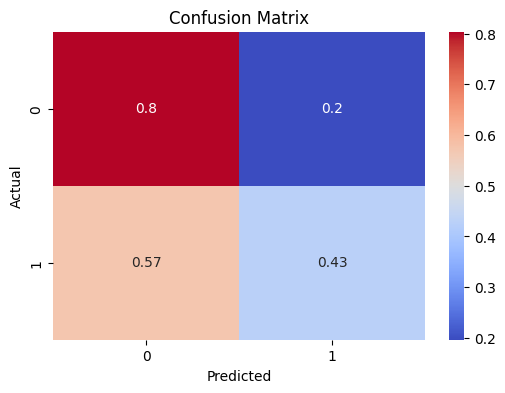

In [25]:
with mlflow.start_run():
    model = SVC(class_weight={0:1, 1:3.8}, **study.best_params).fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    mlflow.log_param("model", "svm_best")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)
    mlflow.log_params(study.best_params)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

In [23]:
# Search for all runs
runs = mlflow.search_runs()

# order by "metrics.Accuracy"
runs = runs.sort_values(by=["metrics.ROC_AUC"], ascending=False)
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.ROC_AUC,metrics.Accuracy,params.model,params.gamma,params.C,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.rootRunId,tags.mlflow.job
4,2acf4fd9-9242-45bc-ba65-428ef741bada,85453ebe-e75a-4a14-aed7-f9c46f2c4f98,FINISHED,,2025-01-26 15:38:18.989000+00:00,2025-01-26 15:38:21.120000+00:00,0.660714,0.642857,svm_best,0.1034771612842754,0.10009984310586251,Noam CHRETIENNOT,cyan_dinner_ztxqpkr3,2acf4fd9-9242-45bc-ba65-428ef741bada,None
3,53ac4ff5-f2f5-4ba2-b605-bfb8acc83553,85453ebe-e75a-4a14-aed7-f9c46f2c4f98,FINISHED,,2025-01-26 15:37:35.826000+00:00,2025-01-26 15:37:38.007000+00:00,0.660714,0.642857,svm,0.1034771612842754,0.10009984310586251,Noam CHRETIENNOT,patient_muscle_j353vl0f,53ac4ff5-f2f5-4ba2-b605-bfb8acc83553,None
1,96e3f8ef-5b7d-405c-8e2b-df6d3e34e2c5,85453ebe-e75a-4a14-aed7-f9c46f2c4f98,FINISHED,,2025-01-26 15:37:01.007000+00:00,2025-01-26 15:37:02.972000+00:00,0.642857,0.642857,svm,None,None,Noam CHRETIENNOT,upbeat_tiger_57mlchxw,96e3f8ef-5b7d-405c-8e2b-df6d3e34e2c5,SVM
2,a423c514-d612-46d2-a6c4-1fbb0bc77cdb,85453ebe-e75a-4a14-aed7-f9c46f2c4f98,FINISHED,,2025-01-26 15:37:03.687000+00:00,2025-01-26 15:37:05.797000+00:00,0.598214,0.678571,random forest,None,None,Noam CHRETIENNOT,gentle_cherry_qwxwgxq3,a423c514-d612-46d2-a6c4-1fbb0bc77cdb,None
0,7d213c97-b6bf-4923-b0e8-6f68eb4847ac,85453ebe-e75a-4a14-aed7-f9c46f2c4f98,FINISHED,,2025-01-26 15:36:57.140000+00:00,2025-01-26 15:36:58.943000+00:00,0.580357,0.476190,logistic regression base,None,None,Noam CHRETIENNOT,keen_stomach_wvvdc637,7d213c97-b6bf-4923-b0e8-6f68eb4847ac,None


Hyper-parameter tuning is useless here

# Create a pipeline to train the model

In [29]:
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml.dsl import pipeline
from azure.ai.ml import load_component
parent_dir = ""

clean_data = load_component(source=parent_dir + "envs/clean-data.yml")
train_logistic_regression = load_component(source=parent_dir + "envs/train-model.yml")

@pipeline()
def cancer_classification(pipeline_job_input):
    cleaned_data = clean_data(input_data=pipeline_job_input)
    train_model = train_logistic_regression(training_data=cleaned_data.outputs.output_data)

    return {
        "pipeline_job_transformed_data": cleaned_data.outputs.output_data,
        "pipeline_job_trained_model": train_model.outputs.model,
    }

pipeline_job = cancer_classification(Input(type=AssetTypes.URI_FILE, path="azureml:cancer-data:1"))

In [30]:
# change the output mode
pipeline_job.outputs.pipeline_job_transformed_data.mode = "upload"
pipeline_job.outputs.pipeline_job_trained_model.mode = "upload"
# set pipeline level compute
pipeline_job.settings.default_compute = "aml-cluster"
# set pipeline level datastore
pipeline_job.settings.default_datastore = "workspaceblobstore"

# print the pipeline job again to review the changes
print(pipeline_job)

display_name: cancer_classification
type: pipeline
inputs:
  pipeline_job_input:
    type: uri_file
    path: azureml:cancer-data:1
outputs:
  pipeline_job_transformed_data:
    mode: upload
    type: uri_folder
  pipeline_job_trained_model:
    mode: upload
    type: mlflow_model
jobs:
  cleaned_data:
    type: command
    inputs:
      input_data:
        path: ${{parent.inputs.pipeline_job_input}}
    outputs:
      output_data: ${{parent.outputs.pipeline_job_transformed_data}}
    component:
      $schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
      name: clean_data
      version: '1'
      display_name: clean training data
      type: command
      inputs:
        input_data:
          type: uri_file
      outputs:
        output_data:
          type: uri_folder
      command: python clean-data.py  --input_data ${{inputs.input_data}} --output_data
        ${{outputs.output_data}}
      environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cp

In [31]:
# submit job to workspace
pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="pipeline_cancer"
)
pipeline_job
# you can find the output in 

Uploading src (0.01 MBs): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5587/5587 [00:00<00:00, 67416.71it/s]


Experiment,Name,Type,Status,Details Page
pipeline_cancer,placid_wolf_4t2dtk4g0d,pipeline,NotStarted,Link to Azure Machine Learning studio


In [33]:
aml_url = pipeline_job.studio_url
print("Monitor your job at", aml_url)

Monitor your job at https://ml.azure.com/runs/placid_wolf_4t2dtk4g0d?wsid=/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/housing_prices/workspaces/mlw-housing_prices&tid=413600cf-bd4e-4c7c-8a61-69e73cddf731


# Deploy the models to endpoint

In [35]:
from azure.ai.ml.entities import ManagedOnlineEndpoint

online_endpoint_name = "endpoint-cancer"

endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Online endpoint for MLflow cancer model",
    auth_mode="key",
)

In [36]:
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/score', 'openapi_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/swagger.json', 'name': 'endpoint-cancer', 'description': 'Online endpoint for MLflow cancer model', 'tags': {}, 'properties': {'createdBy': 'Noam CHRETIENNOT', 'createdAt': '2025-01-26T17:16:36.626414+0000', 'lastModifiedAt': '2025-01-26T17:16:36.626414+0000', 'azureml.onlineendpointid': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/housing_prices/providers/microsoft.machinelearningservices/workspaces/mlw-housing_prices/onlineendpoints/endpoint-cancer', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/providers/Microsoft.MachineLearningServices/locations/francecentral/mfeOperationsStatus/oeidp:2eb94f47-70e0-4a00-8f8f-4ce625aea28f:0e2b522a-9db5-4f3e-b678-53

In [37]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

job_name = pipeline_job.name

model = Model(
    path=f"azureml://jobs/{job_name}/outputs/artifacts/paths/model/",
    name="mlflow-diabetes",
    description="Model created from run.",
    type=AssetTypes.MLFLOW_MODEL,
)

In [38]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

model = Model(
    path="./model",
    type=AssetTypes.MLFLOW_MODEL,
    description="my sample mlflow model",
)

In [39]:
from azure.ai.ml.entities import ManagedOnlineDeployment

blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_D2as_v4",
    instance_count=1,
)

In [40]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint endpoint-cancer exists


........................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'endpoint-cancer', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/providers/Microsoft.MachineLearningServices/locations/francecentral/mfeOperationsStatus/odidp:2eb94f47-70e0-4a00-8f8f-4ce625aea28f:08b364d4-00bd-45ce-9528-24a2fae2146b?api-version=2023-04-01-preview'}, 'print_as_yaml': False, 'id': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/housing_prices/providers/Microsoft.MachineLearningServices/workspaces/mlw-housing_prices/onlineEndpoints/endpoint-cancer/deployments/blue', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/ci-housing-all/code/Users/noam.chretiennot/cloud-DP100-project', 'creation_context': <azure.ai.ml._restclient.v2023_04_01_p

In [46]:
# blue deployment takes 100 traffic
endpoint.traffic = {"blue": 100}
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/score', 'openapi_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/swagger.json', 'name': 'endpoint-cancer', 'description': 'Online endpoint for MLflow cancer model', 'tags': {}, 'properties': {'createdBy': 'Noam CHRETIENNOT', 'createdAt': '2025-01-26T17:16:36.626414+0000', 'lastModifiedAt': '2025-01-26T17:27:34.742714+0000', 'azureml.onlineendpointid': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/housing_prices/providers/microsoft.machinelearningservices/workspaces/mlw-housing_prices/onlineendpoints/endpoint-cancer', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/providers/Microsoft.MachineLearningServices/locations/francecentral/mfeOperationsStatus/oeidp:2eb94f47-70e0-4a00-8f8f-4ce625aea28f:44595a3e-798f-4072-a269-10

In [41]:
# Test the blue deployment with some sample data
response = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name="blue",
    request_file="sample-data.json"
)

In [42]:
if response[1] =='1':
    print("Recurrence")
else:
    print("No Recurrence")

No Recurrence


In [43]:
ml_client.online_endpoints.get(name=online_endpoint_name).scoring_uri

'https://endpoint-cancer.francecentral.inference.ml.azure.com/score'

In [47]:
DATA_PLANE_TOKEN = ml_client.online_endpoints.get_keys(name=online_endpoint_name).primary_key
with open(".env", "w") as f:
    f.write(f"API_KEY={DATA_PLANE_TOKEN}\n")

In [ ]:
endpoints = ml_client.online_endpoints.list()
for endp in endpoints:
    print(endp.name)

In [ ]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

In [ ]:
# ml_client.online_endpoints.begin_delete(name=online_endpoint_name)